<a href="https://colab.research.google.com/github/walexi/Class-Mini-Project/blob/main/BBC_News_Classification_Class_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install kaggle textstat optuna-dashboard plotly nbformat optuna tensorflow-text

In [ ]:
import numpy as np
from numpy.typing import NDArray
from typing import List, Any, Tuple
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from itertools import permutations
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from textstat import flesch_reading_ease
import spacy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

import gc
import tensorflow as tf

import optuna
from optuna.visualization import plot_contour, plot_param_importances, plot_optimization_history, plot_slice, plot_parallel_coordinate
import tensorflow_hub as hub

import logging
import sys

import time
import threading
from optuna_dashboard import wsgi
import optuna
from wsgiref.simple_server import make_server

import tensorflow_text as text
# from matplotlib.colors import Normalize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


# Creating blank language object then
# tokenizing words of the sentence
nlp = spacy.load("en_core_web_sm")

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Project Topic: **BBC News Classification with Dictionary-based Non Negative Matrix Factorization**

In [ ]:
# see https://www.kaggle.com/discussions/getting-started/524433
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [ ]:
# download dataset using kaggle API
!kaggle competitions download -c learn-ai-bbc
!unzip learn-ai-bbc.zip

Archive:  learn-ai-bbc.zip
  inflating: BBC News Sample Solution.csv  
  inflating: BBC News Test.csv       
  inflating: BBC News Train.csv      


### Exploratory Data Analysis

In [ ]:
train_data, test_data = pd.read_csv('BBC News Train.csv'), pd.read_csv('BBC News Test.csv')
N_COMPONENTS = len(train_data['Category'].unique())

In [ ]:
print(train_data.info(), '\n\n\n', train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None 


 (1490, 3)


In [ ]:
# from https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf#Feature-Creation,-Selection-and-More-Reduction
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = stopwords.words('english')+add_stop

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
'''
function to clean the text [column: Text]
'''
# stemming removes the last few characters of words unlike lemmatization which considers the context and converts the words to its meaningful base form (called lemma)
def clean_text(text):
    tokenized_text = list(nlp(text))
    tokenized_text = [token.text.lower() for token in tokenized_text] # convert to lowercase
    tokenized_text = [re.sub(r'<.*?>', '', token) for token in tokenized_text] # remove html tags
    tokenized_text = [re.sub(r'https?://\S+|www\.\S+', '',  token) for token in tokenized_text] # remove URLs
    tokenized_text = [re.sub('[^a-z A-Z 0-9-]+', '', token) for token in tokenized_text] #remove punctuations
    tokenized_text = [expandContractions(each, c_re=c_re) for each in tokenized_text]
    tokenized_text = [SnowballStemmer('english').stem(token) for token in tokenized_text] # stemming is faster than lemmatization
    # tokenized_text = [lem.lemmatize(token) for token in tokenized_text] for tokens in tokenized_corpus
    tokenized_text = [re.sub(' +', ' ', token) for token in tokenized_text] #remove extra spaces
    tokenized_text = [re.sub(' ', '', token) for token in tokenized_text] #remove single line
    tokenized_text = [token for token in tokenized_text if token not in stop_words] #remove stopwords
    text = " ".join(tokenized_text)
    # text = TextBlob(text).correct().string #correct spelling
    return text

In [ ]:
train_data['Text'] = train_data['Text'].astype('str')
train_data['Category'] = train_data['Category'].astype('str')

In [ ]:
# extract all the text data into raw_corpus
raw_corpus = train_data['Text'].str.split().values.tolist()
raw_corpus = [w for s in raw_corpus for w in s]

In [ ]:
# frequency of stop words in the unprocessed/raw text data
stopwords_counts = defaultdict(int)
for word in raw_corpus:
    if word in stop_words:
      stopwords_counts[word]+=1
stopwords_counts = sorted(list(stopwords_counts.items()), key=lambda x: x[1], reverse=True)

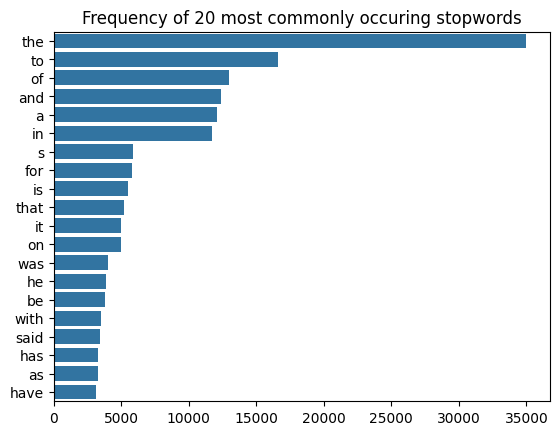

In [ ]:
n_stopwords = 20
plt.title(f'Frequency of {n_stopwords} most commonly occuring stopwords')
sns.barplot(x=[w[1] for w in stopwords_counts[:n_stopwords]], y=[w[0] for w in stopwords_counts[:n_stopwords]])
plt.show()

In [ ]:
# clean text data {Text column}
train_data['cleaned_text'] = train_data['Text'].apply(clean_text)
test_data['cleaned_text'] = test_data['Text'].apply(clean_text)

In [ ]:
processed_corpus = train_data['cleaned_text'].str.split().values.tolist()
processed_corpus = [w for s in processed_corpus for w in s]

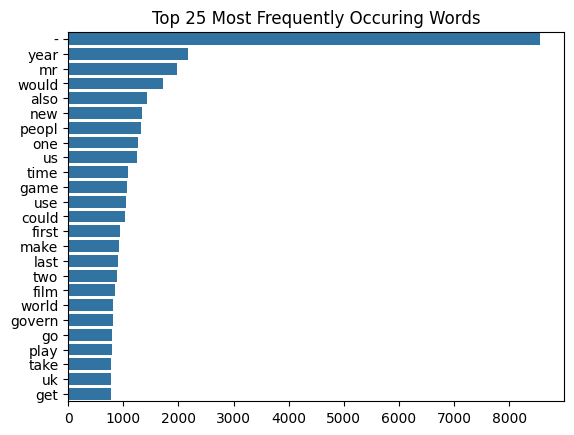

In [ ]:
n_common_words = 25
mostCommon = Counter(processed_corpus).most_common(n_common_words)
words, counts = [w[0] for w in mostCommon], [w[1] for w in mostCommon]
plt.title(f'Top {n_common_words} Most Frequently Occuring Words')
sns.barplot(x=counts, y=words)
plt.show()

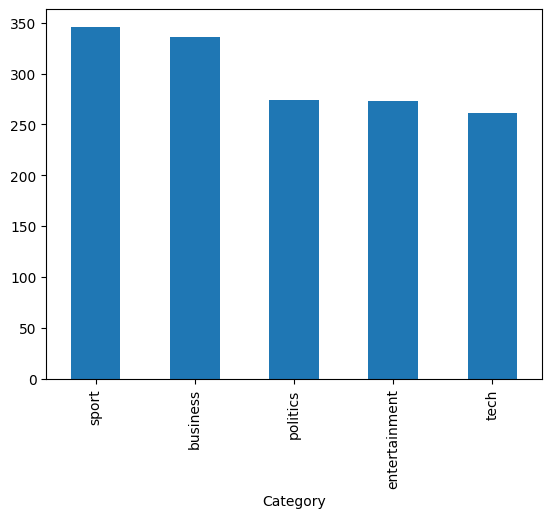

In [ ]:
train_data.Category.value_counts().plot(kind='bar')
plt.show()

**As seen from the plot above, the dataset is moderately balanced.**

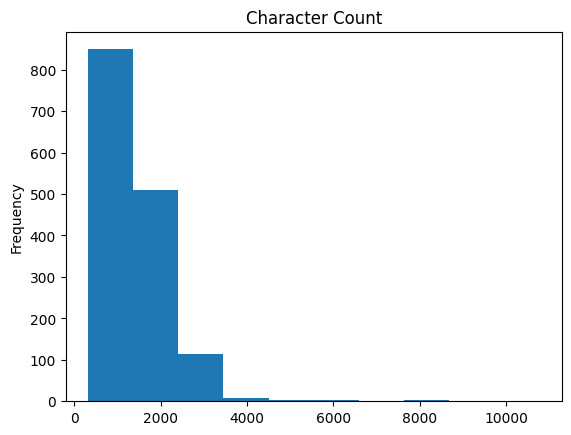

In [ ]:
plt.title('Character Count')
train_data['cleaned_text'].str.len().plot(kind='hist')
plt.show()

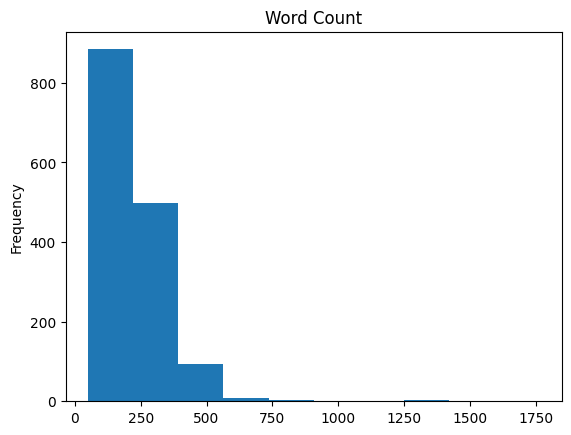

In [ ]:
plt.title('Word Count')
train_data['cleaned_text'].str.split().map(lambda x: len(x)).plot(kind='hist')
plt.show()

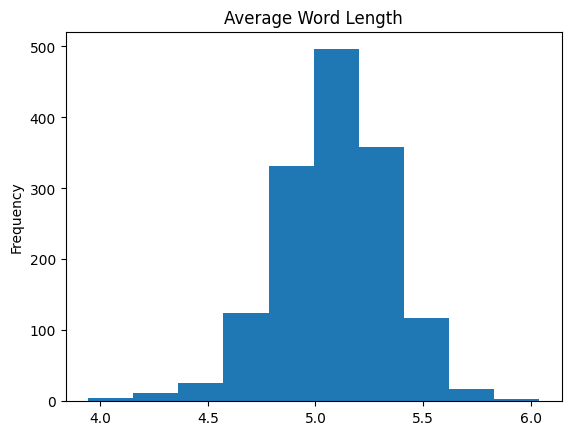

In [ ]:
plt.title('Average Word Length')
train_data['cleaned_text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist')
plt.show()

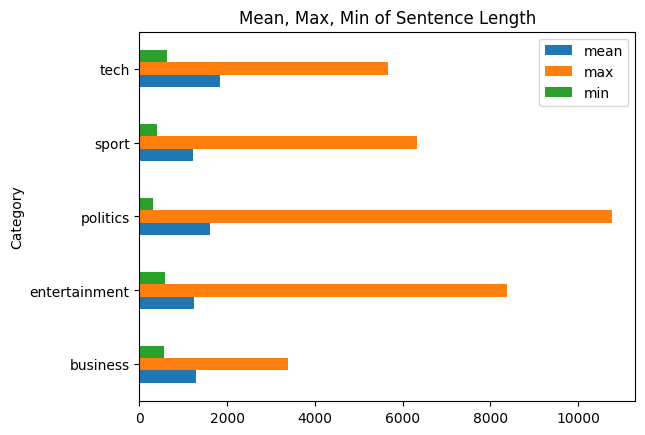

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Mean, Max, Min of Sentence Length')
train_data.groupby('Category').agg(mean=pd.NamedAgg(column='cleaned_text', aggfunc= lambda x: x.str.len().mean()),
                                   max=pd.NamedAgg(column='cleaned_text', aggfunc=lambda x: x.str.len().max()),
                                   min=pd.NamedAgg(column='cleaned_text', aggfunc=lambda x: x.str.len().min())).plot(kind='barh', ax=ax)
plt.show()

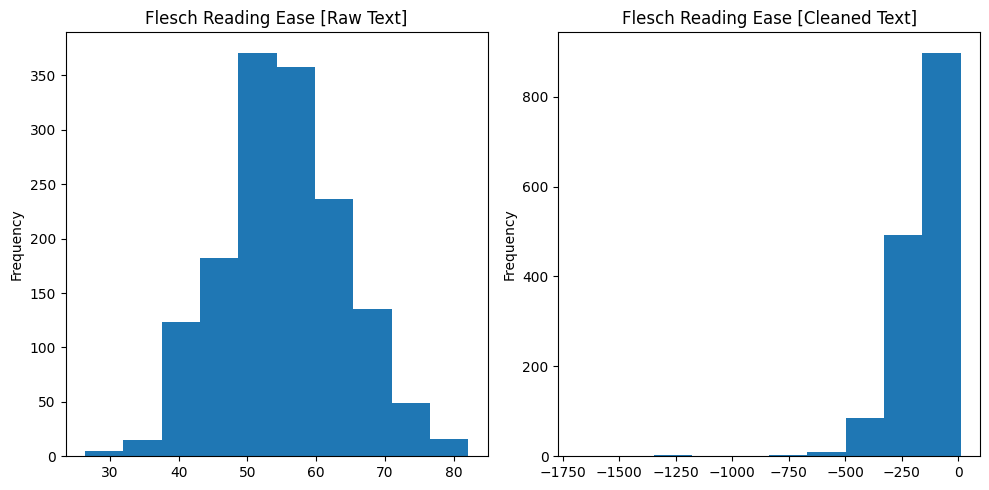

In [ ]:
# lets calculate the complexity of the text content, how easy is it for users to read the news articles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Flesch Reading Ease [Raw Text]')
ax[1].set_title('Flesch Reading Ease [Cleaned Text]')
train_data['Text'].apply(flesch_reading_ease).plot(kind='hist', ax=ax[0])
train_data['cleaned_text'].apply(flesch_reading_ease).plot(kind='hist', ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
train_data.head()

,ArticleId,Text,Category,cleaned_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex - boss launch defenc lawyer defend...
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better f...
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss 168 payout eighteen former enron d...


In [ ]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-cased-l-12-h-768-a-12/4","https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" # @param {type: "string"} ["https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-cased-preprocess/3", "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"]

In [ ]:
"""
function to process raw texts into word embeddings/vectors
"""
def vectorize(data: pd.Series, embed_size:int=1024, model_type: str='tf') -> Tuple[NDArray[np.float32], Any]:
  if model_type=='tf-idf':
    print("Extracting tf-idf features...")
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, min_df=2, max_features=embed_size
    )
    out = tfidf_vectorizer.fit_transform(data['cleaned_text'])
    return out.astype(np.float32).toarray(), tfidf_vectorizer
  elif model_type=='tf':
    print("Extracting tf features...")
    tf_vectorizer = CountVectorizer(
        max_df=0.95, min_df=2, max_features=embed_size
    )
    out = tf_vectorizer.fit_transform(data['cleaned_text'])
    return out.astype(np.float32).toarray(), tf_vectorizer
  elif model_type=='bert': # use gpu plsssss
    print("Extracting features...")
    preprocess = hub.load(PREPROCESS_MODEL)
    bert = hub.load(BERT_MODEL)
    inputs = preprocess(data['Text'].tolist()) # using the raw text gives better result when compared to using the cleaned_text
    out = bert(inputs)
    # clear memory
    tf.keras.backend.clear_session()
    del bert
    del preprocess
    gc.collect()
    # scale values using MinMaxScaler to remove negative entries,
    # especially useful for NMF which requires non-negative matrix
    scaler = MinMaxScaler()
    out = scaler.fit_transform(out['pooled_output'].numpy())
    return out.astype(np.float32), None
  else:
    raise ValueError("model_type must be one of ['tf-idf', 'tf', 'bert']")


## Modelling

### Dataset

In [ ]:
# process the text and train text data into embeddings
train_feat, train_vectorizer = vectorize(train_data, model_type='bert')
test_feat, test_vectorizer = vectorize(test_data, model_type='bert')

enc = OneHotEncoder()
enc = enc.fit(train_data['Category'].values.reshape(-1, 1))

# split data into train and val
x_train, x_test, y_train, y_test = train_test_split(train_feat, train_data['Category'], test_size=0.2, random_state=42)

Extracting features...


127.0.0.1 - - [27/Apr/2025 06:47:22] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 06:47:27] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 06:47:33] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 06:47:38] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 06:47:44] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461


Extracting features...


127.0.0.1 - - [27/Apr/2025 06:47:49] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 06:47:55] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 06:47:59] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 06:48:06] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461


In [ ]:
train_feat.shape, test_feat.shape,

((1490, 768), (735, 768))

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1192, 768), (298, 768), (1192,), (298,))

### Unsupervised ML

Here, I use Dictionary-based Non Negative Matrix Factorization$^{1}$ to classify news articles into categories.<br>
I rephrased the classification task as a clustering problem$^{2}$, where each component can be interpreted as a distinct cluster/topic.<br>
For  $$ V^{i×j} ≈ W^{i×c}  H^{c×j} $$ where **W is the encoding coefficients representing the classification output sequence** and **H is the basis vector representing the normalized mean of within-in component/cluster embeddings.**<br>
As described in $^{2}$ and with a slight modification, I initialized W with the one-hot encoded vector of the target class and H with the mean (I also tried other aggregation operation such as sum and max) of within-in cluster embeddings.<br>
\begin{equation}
H = \Big\Vert_{c=1}^C \frac{\sum_{i\in\mathbb{N}_c} v_{i,j}}{|\mathbb{N}_c|}
\end{equation}
where $v_{i,j}$ is the embedding for entry `i` with `j` embedding size.<br>
Normalization of H and W are as follows (as described in $^{2}$ with some slight modification)
\begin{align}
h_{c,j} ← \frac{h_{c,j}}{\sqrt{\sum_ch_{c,j}^{2}}} \\
w_{i,c} ← w_{i,c} \sqrt{\sum_jh_{c,j}^{2}}
\end{align}

In [ ]:
W = enc.transform(y_train.values.reshape(-1,1)).astype(np.float32)
W.shape

(1192, 5)

In [ ]:
# group data by Category
grouped_data = y_train.groupby(y_train)
# initialize H with intra-cluster embeddings
H = np.vstack([ np.mean(x_train[indices],axis=0) for n, indices in grouped_data.indices.items()])
# normalize as described above
H = np.asarray(H / ( np.sqrt((H**2).sum(axis=0)) + 1e-3)).astype(np.float32) # added 1e-3 for numerical stability
# to fix H full of zeros error by sklearn
H+=1e-3

In [ ]:
# fit NMF model to train_data
model = NMF(
    n_components=N_COMPONENTS,
    solver='mu', # it must be mu for the constraint on W and H to apply
    init='custom',
    beta_loss="frobenius",
    max_iter=1000,
    alpha_W=0.0005,
    alpha_H=0.0005,
    l1_ratio=0.5,
).fit(x_train, W=W.toarray(), H=H)

#### Evaluation

In [ ]:
def visualize_results(y_test: pd.Series | NDArray[np.str_], y_pred: pd.Series | NDArray[np.str_], labels:List[str], name: str='Model', return_score:bool = False):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'--- {name} ---')
  print(classification_report(y_test, y_pred, target_names=labels))
  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix for {name}')
  plt.show()
  if return_score:
    return accuracy

In [ ]:
# map to labels using the optimal label mapping
train_predictions = model.transform(x_train)
val_predictions = model.transform(x_test)
train_predictions = np.multiply(train_predictions , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1)).argmax(axis=1)
val_predictions = np.multiply(val_predictions , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1)).argmax(axis=1)
train_predictions = [enc.categories_[0][i] for i in train_predictions]
val_predictions = [enc.categories_[0][i] for i in val_predictions]
print(f"accuracy on \ntrain is {accuracy_score(y_train, train_predictions)} \nval : {accuracy_score(y_test, val_predictions)}")

accuracy on 
train is 0.5343959731543624 
val : 0.5167785234899329


--- Non Negative Matrix Factorization on the Validation Data ---
               precision    recall  f1-score   support

     business       0.72      0.37      0.49        75
entertainment       0.89      0.35      0.50        46
     politics       0.37      0.66      0.47        56
        sport       0.46      0.84      0.60        63
         tech       0.77      0.34      0.48        58

     accuracy                           0.52       298
    macro avg       0.64      0.51      0.51       298
 weighted avg       0.63      0.52      0.51       298



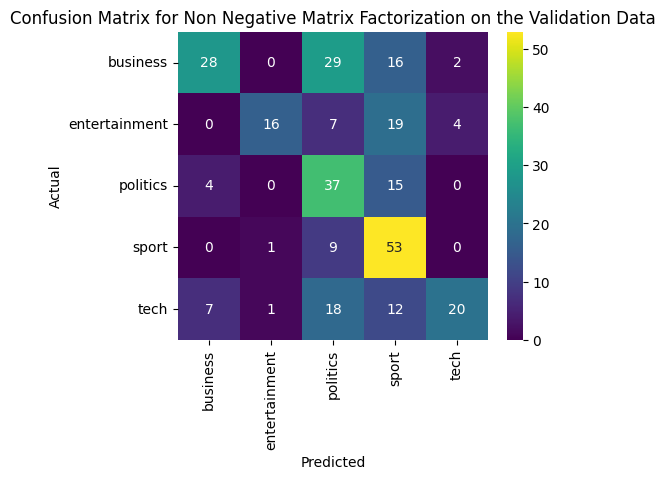

In [ ]:
visualize_results(y_test, val_predictions, enc.categories_[0], name='Non Negative Matrix Factorization on the Validation Data')

#### Hyperparameter Optimization Using Optuna

In [ ]:
NUM_TRIALS = 100

In [ ]:
def objective(trial):

    EMBED_SIZE  = trial.suggest_int('embed_size', 1024, 1024*6, step=1024)
    MODEL_TYPE = trial.suggest_categorical('model_type', ['tf-idf', 'tf', 'bert'])
    DATA_SIZE = trial.suggest_categorical('data_size', [0.2, 0.5, 0.8])

    train_feat, _ = vectorize(train_data, EMBED_SIZE, MODEL_TYPE)

    # split data to train and val to fit and evaluate model
    x_train, x_test, y_train, y_test = train_test_split(train_feat, train_data['Category'], train_size=DATA_SIZE, random_state=42)

    W = enc.transform(y_train.values.reshape(-1,1)).astype(np.float32)
    # group data by Category
    grouped_data = y_train.groupby(y_train)
    # initialize H with intra-cluster embeddings
    H = np.vstack([ np.mean(x_train[indices],axis=0) for n, indices in grouped_data.indices.items()])
    # normalize as described above
    H = np.asarray(H / (np.sqrt((H**2).sum(axis=0))).astype(np.float32) + 1e-3) # add 1e-3 for numerical stability
    # to fix H full of zeros error by sklearn
    H+=1e-2

    model = NMF(
        n_components=N_COMPONENTS,
        solver='mu',
        init='custom',
        beta_loss='frobenius',
        alpha_W=trial.suggest_float('alpha_W', 1e-5, 1e-2, log=True),
        alpha_H=trial.suggest_float('alpha_H', 1e-5, 1e-2, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
        max_iter= 10000
        ).fit(x_train, W=W.toarray(), H=H)

    train_predictions = model.transform(x_train)
    val_predictions = model.transform(x_test)
    train_predictions = np.multiply(train_predictions , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1))
    val_predictions = np.multiply(val_predictions , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1))
    train_predictions = train_predictions.argmax(axis=1)
    train_predictions = [enc.categories_[0][i] for i in train_predictions]
    val_predictions = val_predictions.argmax(axis=1)
    val_predictions = [enc.categories_[0][i] for i in val_predictions]

    train_score = accuracy_score(y_train, train_predictions)
    val_score = accuracy_score(y_test, val_predictions)
    # maximizing the val_score and minimizing the difference between the val and train scores (this help track overfitting)
    return val_score, train_score-val_score

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "bbc_news_project"  # Unique identifier of the study.
storage = optuna.storages.InMemoryStorage()
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, directions=["maximize", "minimize"], load_if_exists=True)
study.set_metric_names(["val_accuracy_score", "train_score-val_score"])

study.optimize(objective, n_trials=NUM_TRIALS, timeout=600)

In [ ]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

t1 = max(study.best_trials, key=lambda t: t.values[0])
print("Trial with highest accuracy: ")
print(f"\tnumber: {t1.number}")
print(f"\tparams: {t1.params}")
print(f"\tvalues: {t1.values}")
t2 = max(study.best_trials, key=lambda t: t.values[1])
print("Trial with best generalization capability (val_accuracy-train_accuracy): ")
print(f"\tnumber: {t2.number}")
print(f"\tparams: {t2.params}")
print(f"\tvalues: {t2.values}")

Number of trials on the Pareto front: 3
Trial with highest accuracy: 
	number: 6
	params: {'embed_size': 1024, 'model_type': 'tf-idf', 'data_size': 0.5, 'alpha_W': 4.21807602819832e-05, 'alpha_H': 1.6459367229533616e-05, 'l1_ratio': 0.8648416884595065}
	values: [0.959731543624161, -0.01744966442953011]
Trial with best generalization capability (val_accuracy-train_accuracy): 
	number: 6
	params: {'embed_size': 1024, 'model_type': 'tf-idf', 'data_size': 0.5, 'alpha_W': 4.21807602819832e-05, 'alpha_H': 1.6459367229533616e-05, 'l1_ratio': 0.8648416884595065}
	values: [0.959731543624161, -0.01744966442953011]


In [ ]:
# run this cell to view the optuna dashboard in another window (following the link in the output cell)
# https://stackoverflow.com/questions/76033104/launching-optuna-dashboard-in-google-colaboratory
port =  9005
storage = optuna.storages.RDBStorage(f"sqlite:////content/{study_name}.db")
app = wsgi(storage)
httpd = make_server("localhost", port, app)
thread = threading.Thread(target=httpd.serve_forever)
thread.start()
time.sleep(3) # Wait until the server startup

from google.colab import output
output.serve_kernel_port_as_window(port, path='/dashboard/') # follow the link in the output cell below to view the dashboard

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

**Alternatively, run the cells below to see the output of the hyperparameter tuning**

In [ ]:
optuna.visualization.plot_pareto_front(study, target_names=["val_accuracy_score", "train_score-val_score"])

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="val_accuracy_score"
)

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="train_score-val_score"
)

In [ ]:
optuna.visualization.plot_contour(study, target=lambda t: t.values[0], target_name="val_accuracy_score")

127.0.0.1 - - [27/Apr/2025 06:29:40] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254


In [ ]:
optuna.visualization.plot_contour(study, target=lambda t: t.values[1], target_name="train_score-val_score")

In [ ]:
plot_parallel_coordinate(study, target=lambda t: t.values[0], target_name="val_accuracy_score")

In [ ]:
plot_parallel_coordinate(study, target=lambda t: t.values[1], target_name="train_score-val_score")

### Supervised ML

In [ ]:
# Define models
models = {
    'LR': (LogisticRegression(), 'Logistic Regression'),
    'RF': (RandomForestClassifier(n_estimators=500), 'Random Forest'),
    'SVM': (SVC(), 'Support Vector Machines'),
    'KNN': (KNeighborsClassifier(), 'K-Nearest Neighbors'),
    'DT': (DecisionTreeClassifier(), 'Decision Trees'),
    'NB': (GaussianNB(), 'Guassian Naive Bayes')
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



--- Logistic Regression ---
               precision    recall  f1-score   support

     business       0.93      0.95      0.94        75
         tech       0.92      0.96      0.94        46
     politics       0.95      0.95      0.95        56
        sport       0.98      1.00      0.99        63
entertainment       0.96      0.90      0.93        58

     accuracy                           0.95       298
    macro avg       0.95      0.95      0.95       298
 weighted avg       0.95      0.95      0.95       298



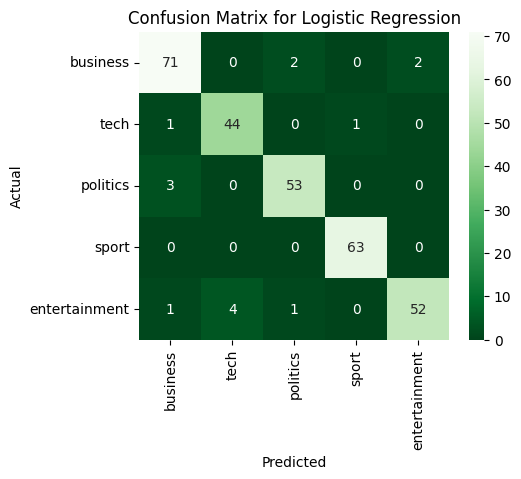

127.0.0.1 - - [27/Apr/2025 07:10:15] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254


--- Random Forest ---
               precision    recall  f1-score   support

     business       0.78      0.93      0.85        75
         tech       0.83      0.96      0.89        46
     politics       0.87      0.86      0.86        56
        sport       0.98      0.97      0.98        63
entertainment       1.00      0.66      0.79        58

     accuracy                           0.88       298
    macro avg       0.89      0.87      0.87       298
 weighted avg       0.89      0.88      0.87       298



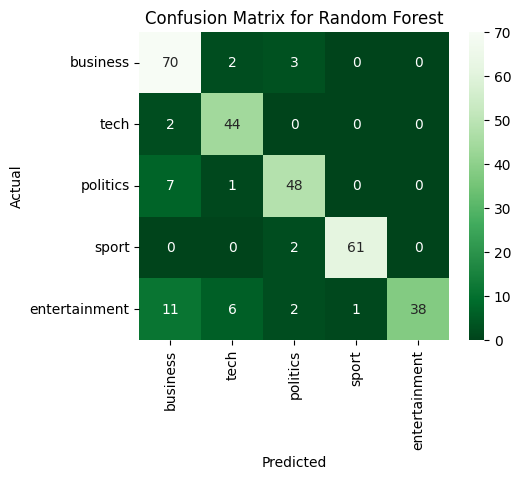

127.0.0.1 - - [27/Apr/2025 07:10:28] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 07:10:28] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254


--- Support Vector Machines ---
               precision    recall  f1-score   support

     business       0.88      0.95      0.91        75
         tech       0.85      0.96      0.90        46
     politics       0.95      0.93      0.94        56
        sport       1.00      0.98      0.99        63
entertainment       0.96      0.79      0.87        58

     accuracy                           0.92       298
    macro avg       0.93      0.92      0.92       298
 weighted avg       0.93      0.92      0.92       298



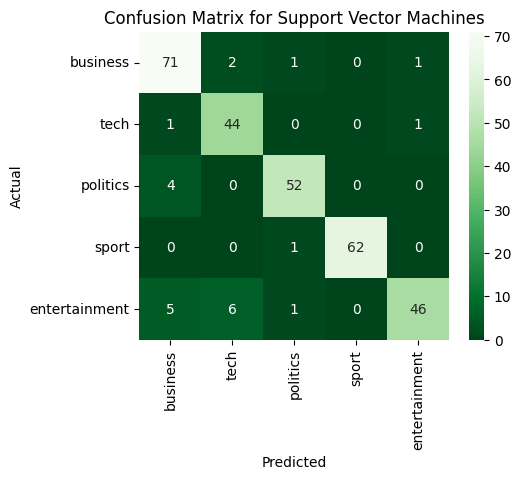



--- K-Nearest Neighbors ---
               precision    recall  f1-score   support

     business       0.71      0.87      0.78        75
         tech       0.83      0.76      0.80        46
     politics       0.72      0.86      0.78        56
        sport       1.00      0.81      0.89        63
entertainment       0.87      0.71      0.78        58

     accuracy                           0.81       298
    macro avg       0.83      0.80      0.81       298
 weighted avg       0.82      0.81      0.81       298



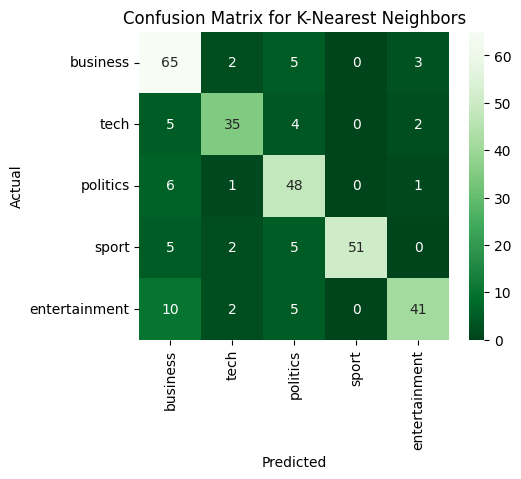



--- Decision Trees ---
               precision    recall  f1-score   support

     business       0.59      0.57      0.58        75
         tech       0.52      0.50      0.51        46
     politics       0.66      0.68      0.67        56
        sport       0.64      0.73      0.68        63
entertainment       0.65      0.57      0.61        58

     accuracy                           0.61       298
    macro avg       0.61      0.61      0.61       298
 weighted avg       0.61      0.61      0.61       298



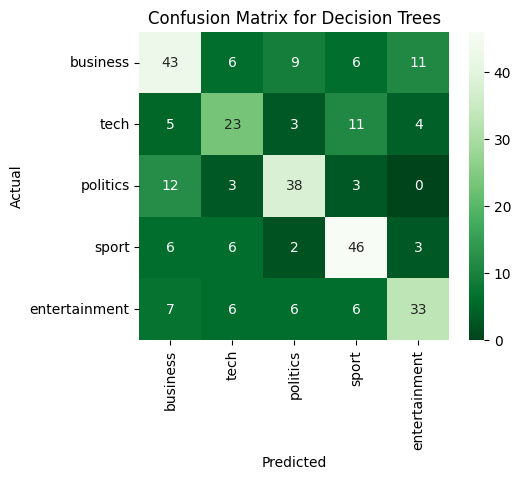



--- Guassian Naive Bayes ---
               precision    recall  f1-score   support

     business       0.80      0.11      0.19        75
         tech       0.40      0.04      0.08        46
     politics       0.39      0.91      0.55        56
        sport       0.65      0.57      0.61        63
entertainment       0.39      0.66      0.49        58

     accuracy                           0.45       298
    macro avg       0.53      0.46      0.38       298
 weighted avg       0.55      0.45      0.39       298



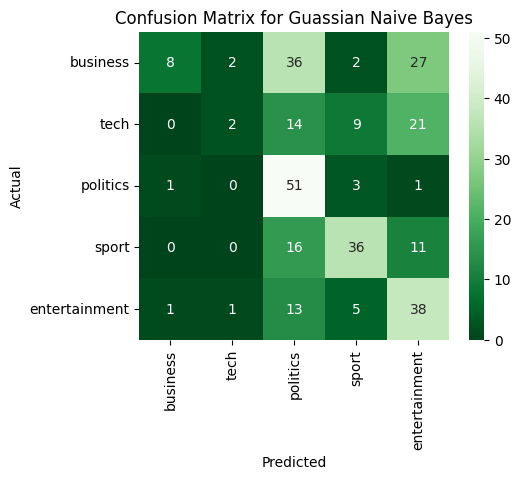

In [ ]:
# Train and evaluate models
accuracy_scores = []
labels = train_data['Category'].unique().tolist()
for _, (model, name) in models.items():
    model.fit(x_train, y_train)
    t_pred = model.predict(x_train)
    y_pred = model.predict(x_test)
    train_score = accuracy_score(y_train, t_pred)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append((name, accuracy, train_score))
    print(f'--- {name} ---')
    print(classification_report(y_test, y_pred, target_names=labels))
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens_r', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print('\n')


In [ ]:
accuracy_scores

[('Logistic Regression', 0.9496644295302014, 0.985738255033557),
 ('Random Forest', 0.8758389261744967, 1.0),
 ('Support Vector Machines', 0.9228187919463087, 0.9312080536912751),
 ('K-Nearest Neighbors', 0.8053691275167785, 0.8565436241610739),
 ('Decision Trees', 0.6140939597315436, 1.0),
 ('Guassian Naive Bayes', 0.45302013422818793, 0.4471476510067114)]

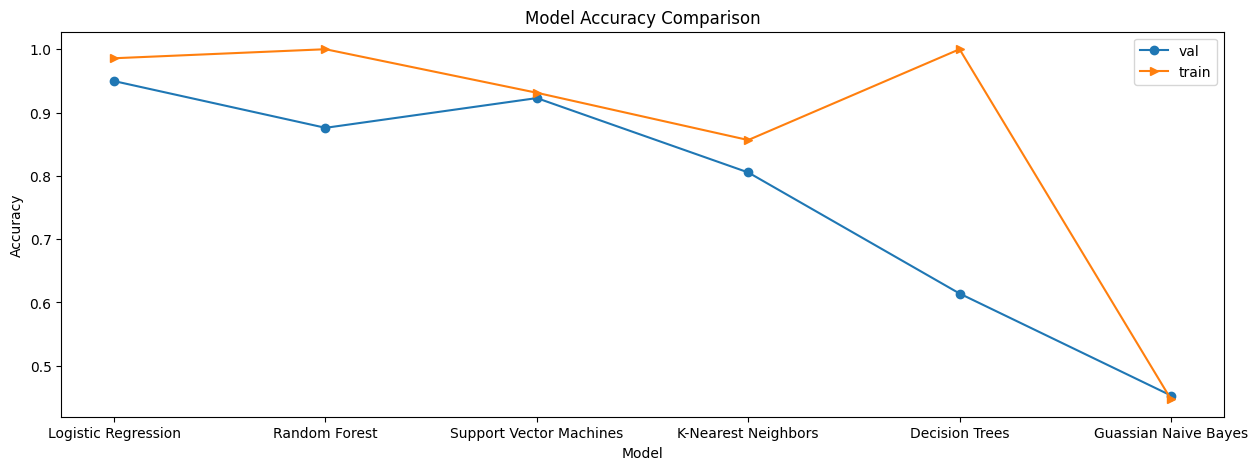

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot([score[0] for score in accuracy_scores], [score[1] for score in accuracy_scores], marker='o', label='val')
plt.plot([score[0] for score in accuracy_scores], [score[2] for score in accuracy_scores], marker='>', label='train')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.show()

In [ ]:
m, s, _ = max(accuracy_scores, key=lambda x: x[1])
print(f'Best performing supervised learning method is \n{m} with \naccuracy score of {s}')

Best performing supervised learning method is 
Logistic Regression with 
accuracy score of 0.9496644295302014


### Supervised/Unsupervised

In [ ]:
# Train and evaluate models

models['NMF'] = (NMF(
    n_components=N_COMPONENTS,
    solver='mu', # it must be mu for the constraint on W and H to apply
    init='custom',
    beta_loss="frobenius",
    max_iter=1000,
    alpha_W=0.0005,
    alpha_H=0.0005,
    l1_ratio=0.5
  ), 'Non-Negative Matrix Factorization')

accuracy_scores = defaultdict(list)
labels = train_data['Category'].unique().tolist()
data_sizes = [0.1, 0.2, 0.5, 0.8]

for idx, data_size in enumerate(data_sizes):
  # Number of rows to randomly select
  num_rows = int(data_size * x_train.shape[0])
  # Generate random indices
  indices = np.random.choice(x_train.shape[0], size=num_rows, replace=True)
  x, y = x_train[indices.tolist()], np.take(y_train, indices, axis=0)
  val_scores = []
  train_scores = []
  for name, (model, _) in models.items():
    if name == 'NMF':
      W = enc.transform(y.values.reshape(-1,1)).astype(np.float32)

      # group data by Category
      grouped_data = y.groupby(y)
      # initialize H with intra-cluster embeddings
      H = np.vstack([ np.mean(x[indices],axis=0) for n, indices in grouped_data.indices.items()])
      # normalize as described above
      H = np.asarray(H / np.sqrt((H**2).sum(axis=0))).astype(np.float32)
      # to fix H full of zeros error by sklearn
      H+=1e-3
      model = model.fit(x, W=W.toarray(), H=H)
      train_pred = model.transform(x)
      train_pred = np.multiply(train_pred , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1)).argmax(axis=1)
      train_pred = [enc.categories_[0][i] for i in train_pred]
      test_pred = model.transform(x_test)
      test_pred = np.multiply(test_pred , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1)).argmax(axis=1)
      test_pred = [enc.categories_[0][i] for i in test_pred]
    else:
      model = model.fit(x, y)
      train_pred = model.predict(x)
      test_pred = model.predict(x_test)
    train_score = accuracy_score(y, train_pred)
    val_score = accuracy_score(y_test, test_pred)
    train_scores.append(train_score)
    val_scores.append(val_score)
  accuracy_scores['train'].append(train_scores)
  accuracy_scores['val'].append(val_scores)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

127.0.0.1 - - [27/Apr/2025 07:10:50] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 07:10:50] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docume

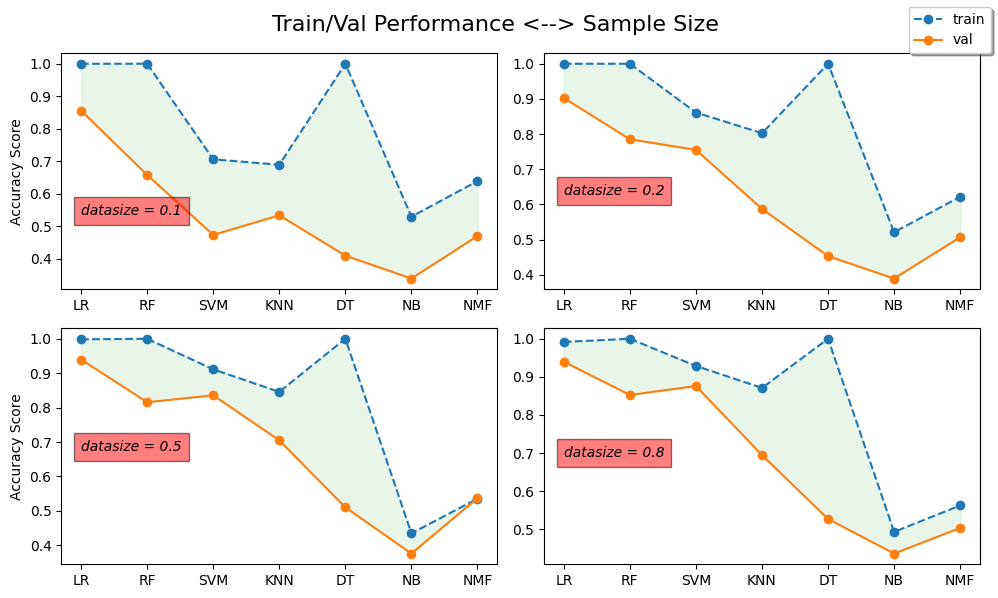

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

model_names = list(models.keys())
for si, s in enumerate(data_sizes):
  ax_i = ax[si//2, si%2]
  t = accuracy_scores['train'][si]
  v = accuracy_scores['val'][si]
  l1 = ax_i.plot(model_names, t, color = ax_i._get_lines.get_next_color(), marker='o', label='train', linestyle='--')
  l2 = ax_i.plot(model_names, v, color = ax_i._get_lines.get_next_color(), marker='o', label='val', linestyle='-')
  ax_i.fill_between(model_names, t, v, color=ax_i._get_lines.get_next_color(), alpha=0.1)
  if si%2==0: ax_i.set_ylabel("Accuracy Score")
  ax_i.text(model_names[v.index(max(v))], min(np.mean(t), np.mean(v)), f'datasize = {s}', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})


handles, labels = ax_i.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', shadow=True)
# fig.subplots_adjust(right=0.2)
fig.suptitle('Train/Val Performance <--> Sample Size', fontsize=16)
fig.tight_layout()
# plt.legend()
plt.show()

## Disussion and Conclusion

**Data-efficiency**<br>
Support Vector Machines, Random Forest, Decision Tress, Guassian Navie Bayes and Non Negative Matrix Factorization -> performance of models increases with sample size<br>
Logistic Regression and K-Nearest Neighbor => performance of models stays fairly the same across the sample size - data-efficient learning methods<br>
**Overfitting**<br>
NMF, KNN(with smaller sample size), RF, SVM, and LR seem to generalize (do not overfit) better when compared with the other models<br>
**Dimension of embeddings**<br>
Increasing the dimension of the embedding space improves the model performance. The effect was especially pronounced in the case of BERT (language models)

### Kaggle Submission

#### Unsupervised ML

In [ ]:
# kaggle submission
train_feat, _ = vectorize(train_data, model_type='bert')
test_feat, _ = vectorize(test_data, model_type='bert')

W = enc.transform(train_data['Category'].values.reshape(-1,1)).astype(np.float32)

grouped_data = train_data.groupby('Category')
H = np.vstack([ np.mean(train_feat[indices],axis=0) for n, indices in grouped_data.indices.items()])
H = np.asarray(H / np.sqrt((H**2).sum(axis=0))).astype(np.float32)
H+=1e-3

# fit NMF model to train_data
model = NMF(
    n_components=N_COMPONENTS,
    random_state=1,
    solver='mu',
    init='custom',
    beta_loss="frobenius",
    alpha_W=4.21807602819832e-05,
    alpha_H=1.6459367229533616e-05,
    l1_ratio=0.8648416884595065,
).fit(train_feat, W=W.toarray(), H=H)

test_predictions = model.transform(test_feat)
test_predictions = np.multiply(test_predictions , np.sqrt((model.components_**2).sum(axis=1)).reshape(1,-1)).argmax(axis=1)

test_predictions = [enc.categories_[0][i] for i in test_predictions]

submission_df = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_predictions})
submission_df.to_csv('submission.csv', index=False)

Extracting features...


127.0.0.1 - - [27/Apr/2025 07:07:25] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 07:07:29] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 07:07:36] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 07:07:40] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 07:07:47] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461


Extracting features...


127.0.0.1 - - [27/Apr/2025 07:07:51] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
127.0.0.1 - - [27/Apr/2025 07:07:58] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461
127.0.0.1 - - [27/Apr/2025 07:08:02] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
!kaggle competitions submit -c learn-ai-bbc  -f submission.csv -m "Submission via API"

127.0.0.1 - - [27/Apr/2025 07:08:09] "GET /api/studies/1?after=11 HTTP/1.1" 200 8461


100% 8.71k/8.71k [00:00<00:00, 15.2kB/s]
Successfully submitted to BBC News Classification

In [ ]:
!kaggle competitions submissions -c learn-ai-bbc

fileName        date                        description         status                     publicScore  privateScore  
--------------  --------------------------  ------------------  -------------------------  -----------  ------------  
submission.csv  2025-04-27 07:08:10.397000  Submission via API  SubmissionStatus.COMPLETE  0.48571      0.48571       
submission.csv  2025-04-27 07:01:07.993000  Submission via API  SubmissionStatus.COMPLETE  0.48707      0.48707       
submission.csv  2025-04-27 06:59:59.900000  Submission via API  SubmissionStatus.COMPLETE  0.23401      0.23401       
submission.csv  2025-04-27 03:09:38.577000  Submission via API  SubmissionStatus.COMPLETE  0.50884      0.50884       
submission.csv  2025-04-27 03:08:28.533000  Submission via API  SubmissionStatus.COMPLETE  0.19183      0.19183       
submission.csv  2025-04-27 03:06:57.993000  Submission via API  SubmissionStatus.COMPLETE  0.25714      0.25714       
submission.csv  2025-04-26 22:55:28.373000  Subm

#### Supervised ML

In [ ]:
m = LogisticRegression()
m = m.fit(train_feat, train_data['Category'])
p = m.predict(test_feat)
submission_df = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': p})
submission_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
!kaggle competitions submit -c learn-ai-bbc  -f submission.csv -m "Submission via API"

100% 9.31k/9.31k [00:00<00:00, 16.9kB/s]


127.0.0.1 - - [27/Apr/2025 07:11:56] "GET /api/studies/1?after=11 HTTP/1.1" 200 16254


Successfully submitted to BBC News Classification

In [ ]:
!kaggle competitions submissions -c learn-ai-bbc

fileName        date                        description         status                     publicScore  privateScore  
--------------  --------------------------  ------------------  -------------------------  -----------  ------------  
submission.csv  2025-04-27 07:11:55.690000  Submission via API  SubmissionStatus.COMPLETE  0.92517      0.92517       
submission.csv  2025-04-27 07:11:32.747000  Submission via API  SubmissionStatus.COMPLETE  0.90748      0.90748       
submission.csv  2025-04-27 07:09:31.627000  Submission via API  SubmissionStatus.COMPLETE  0.92517      0.92517       
submission.csv  2025-04-27 07:09:13.160000  Submission via API  SubmissionStatus.COMPLETE  0.86802      0.86802       
submission.csv  2025-04-27 07:08:10.397000  Submission via API  SubmissionStatus.COMPLETE  0.48571      0.48571       
submission.csv  2025-04-27 07:01:07.993000  Submission via API  SubmissionStatus.COMPLETE  0.48707      0.48707       
submission.csv  2025-04-27 06:59:59.900000  Subm

## References
1. Somnuk Phon-Amnuaisuk, Applying Non-negative Matrix Factorization to Classify Superimposed Handwritten Digits, Procedia Computer Science, Volume 24, 2013, Pages 261-267, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2013.10.049.
2. C. H. Q. Ding, T. Li and M. I. Jordan, "Convex and Semi-Nonnegative Matrix Factorizations," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 32, no. 1, pp. 45-55, Jan. 2010, doi: 10.1109/TPAMI.2008.277,

